In [215]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from scipy import stats, optimize

In [216]:
def create_master_dark(file_template, num_frames):
    """
This line defines a function named create_master_dark that takes two parameters: 
file_template and num_frames.
file_template: A string that contains the file path template for the dark frame files, 
with a placeholder for the frame number.
num_frames: An integer representing how many dark frames will be processed.

    Create a master dark frame by median-combining dark frames.
    
    :param file_template: Template path for the dark frame files with placeholders for the frame number.
    :type file_template: str
    :param num_frames: The number of dark frames to combine.
    :type num_frames: int
    :return: Master dark frame (2D numpy array), Stack of individual dark frames (3D numpy array)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # List to store the data from each dark frame
    dark_frames_data = []

    # Initializes an empty list called dark_frames_data, 
    # which will be used to store the pixel data from each individual dark frame.


    # Loop through each dark frame and read the data
    for i in range(num_frames):
        #starts a loop that will iterate num_frames times. 
        # The variable i will take values from 0 to num_frames - 1. 
        # This is used to process each dark frame individually.

        # Construct the file name based on the frame number
        file_path = file_template.format(i)

        # This line uses the file_template.format(i) method to generate the file path 
        # for the i-th dark frame by replacing the placeholder in file_template with the value of i. 
        # For example, if i = 5, it will generate a file path like 
        # ..\FITS_Files\3.2.3_10_dark_frames_30_sec.00000005.DARK.FIT.

        # Open the FITS file and extract the data
        with fits.open(file_path) as hdul:
            dark_frames_data.append(hdul[0].data)
        # Uses the fits.open() function from the astropy.io.fits library 
        # to open the FITS file specified by file_path. 
        # The opened file is stored in hdul, which stands for Header Data Unit List.

    # Stack the frames into a 3D array "stacked_frames"(stack of 2D frames)
    # Each slice along the first axis (axis=0) corresponds to a different dark frame.
    stacked_frames = np.stack(dark_frames_data, axis=0)
    # This line calculates the median pixel value across all frames for each pixel position. 
    # It uses np.median() along the first axis (axis=0), which corresponds to the stack of frames. 
    # The result is a 2D array called master_dark_frame that represents the final master dark frame.
    master_dark_frame = np.median(stacked_frames, axis=0)
    
    return master_dark_frame, stacked_frames


# Template for the file names (with placeholder for frame number)
file_template = r"..\FITS_Files\3.2.3_10_dark_frames_30_sec.{:08d}.DARK.FIT"
# This defines the file_template, 
# which contains the file path format with a placeholder ({:08d}) for the frame number.

# Number of dark frames to combine
num_frames = 10
# Create the master dark frame and get the individual frames
master_dark_frame, dark_frames = create_master_dark(file_template, num_frames)

In [217]:
# Calculate the median value of the master dark frame
median_value = np.median(master_dark_frame)

# Output the median value
print(f"Median value of the master dark frame: {median_value}")

Median value of the master dark frame: 1022.0


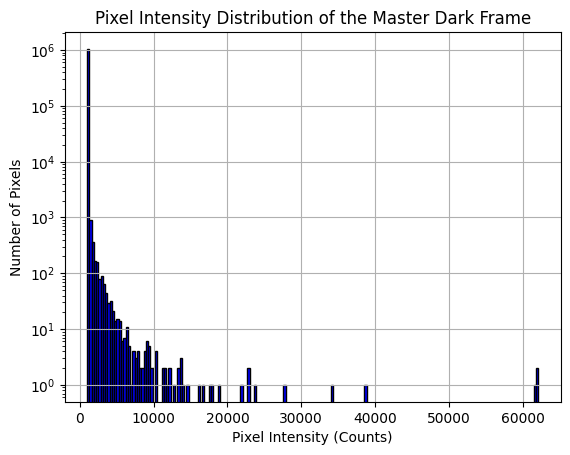

In [218]:
# Flattening the data into a 1D array
flattened_data = master_dark_frame.flatten()

# This line takes the 2D array master_dark_frame and flattens it into a 1D array.
# The .flatten() method in numpy returns a copy of the array collapsed into one dimension. 
# Instead of working with a 2D grid of pixel intensities, 
# the data is now in a single list, where each pixel's value is an element.

# Plot the histogram of pixel intensities for the median dark frame
plt.figure()
plt.hist(flattened_data, range = (np.min(flattened_data), np.max(flattened_data)), bins=200, log=True, color='blue', edgecolor='black')
plt.title('Pixel Intensity Distribution of the Master Dark Frame')
plt.xlabel('Pixel Intensity (Counts)')
plt.ylabel('Number of Pixels')
plt.grid(True)
# This line adds a grid to the plot, making it easier to read values from the axes.

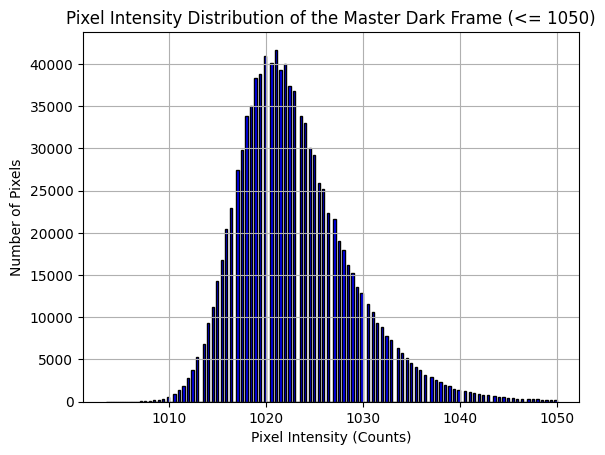

In [219]:
# Filtering the data to include only values less than or equal to the median maximum
med_max = 1050
# sets a threshold value of 1050 for the pixel intensities.
# med_max is set to be the maximum pixel intensity value to include in the analysis. 
# Any pixel with an intensity greater than this value will be filtered out.
filtered_data = flattened_data[flattened_data <= med_max]
# This line filters the flattened pixel intensity data to include 
# only the values that are less than or equal to the med_max threshold.

# Plot the new histogram 
plt.figure()
# This line initializes a new figure for the filtered data histogram. 
# It ensures that the new plot is drawn on a separate canvas.
plt.hist(filtered_data, range = (np.min(filtered_data), np.max(filtered_data)), bins=200, color='blue', edgecolor='black')
plt.title('Pixel Intensity Distribution of the Master Dark Frame (<= 1050)')
plt.xlabel('Pixel Intensity (Counts)')
plt.ylabel('Number of Pixels')
plt.grid(True)

In [220]:
# Initialize lists for hot and warm pixels
hot_pixels = []
warm_pixels = []
# These two lines initialize empty lists, hot_pixels and warm_pixels, 
# to store the coordinates of pixels that meet specific intensity criteria 
# (hot and warm pixels).

# Iterate over each pixel in the median dark frame
for i in range(master_dark_frame.shape[0]):
    for j in range(master_dark_frame.shape[1]):
        if master_dark_frame[i, j] >= 20000:  # Hot pixel threshold
            hot_pixels.append([i, j])  # Store as [row, col] (i, j)
        # This block checks if a pixel’s intensity at coordinates (i, j) is greater than or equal to 20000. 
        # If it is, the pixel is considered a "hot" pixel.

        elif 10000 < master_dark_frame[i, j] < 20000:  # Warm pixel range
            warm_pixels.append([i, j])  # Store as [row, col] (i, j)
        # This block checks if the pixel intensity falls within the range of 
        # 10000 < pixel value < 20000, classifying the pixel as "warm."
        # Warm pixels have moderate intensity values 
        # (higher than the typical background noise but not as extreme as hot pixels).

# Calculate the total number of pixels in the median dark frame
total_pixels = master_dark_frame.size
# master_dark_frame.size gives the total number of elements (pixels) in the 2D array, 
# which is equivalent to the product of the number of rows and columns (height × width).

# Calculate the fraction of rejected pixels
fraction_of_rejected_pixels = (len(hot_pixels) + len(warm_pixels)) / total_pixels
# This line calculates the fraction of "rejected" pixels, 
# which includes both hot and warm pixels.

# len(hot_pixels) + len(warm_pixels) gives the total number of hot and warm pixels.

# Dividing this by total_pixels gives the fraction of the 
# total image that consists of these rejected pixels.

# Output the results
print(f"Hot pixels: {hot_pixels}")
print(f"Warm pixels: {warm_pixels}")

Hot pixels: [[67, 968], [189, 347], [350, 36], [359, 705], [409, 329], [495, 198], [610, 230], [718, 468], [915, 766], [1022, 31]]
Warm pixels: [[28, 129], [77, 1023], [87, 911], [110, 5], [216, 431], [321, 153], [327, 395], [383, 665], [396, 913], [400, 444], [402, 464], [443, 329], [490, 453], [497, 265], [551, 987], [565, 909], [608, 987], [660, 95], [687, 949], [797, 107], [833, 641], [858, 263], [909, 662], [967, 889], [992, 374], [998, 550]]


In [221]:
# Initialize lists for visibility checks
hot_pixels_in_all_frames = []
# Stores the coordinates of hot pixels that appear in all dark frames.
warm_pixels_in_all_frames = []
# Stores the coordinates of warm pixels that appear in all dark frames.
hot_pixels_in_median_only = []
# Stores the coordinates of hot pixels that appear only in the master dark frame 
# (median frame), but not in all individual dark frames.
warm_pixels_in_median_only = []
# Stores the coordinates of warm pixels that appear only in the master dark frame 
# (median frame), but not in all individual dark frames.
hot_pixels_in_both = []
# Stores the coordinates of hot pixels that appear in 
# both the median frame and some (but not all) dark frames.
warm_pixels_in_both = []
# Stores the coordinates of warm pixels that appear in 
# both the median frame and some (but not all) dark frames.

# These six lists are initialized to store the 
# coordinates of hot and warm pixels based on different conditions

# Check each pixel in the list of hot and warm pixels
for pixel in hot_pixels:
    i, j = pixel
    # This loop iterates over all coordinates in the hot_pixels list.
    # i, j = pixel unpacks the row and column coordinates of each hot pixel, 
    # assigning the row index to i and the column index to j.
    appears_in_all_frames = all(dark_frame[i, j] >= 20000 for dark_frame in dark_frames)
    # This line checks if the current hot pixel (located at (i, j)) appears as a hot pixel in all dark frames.
    # The all() function returns True if the pixel's value is greater than or equal to 20000 in every dark frame 
    # (dark_frames is a 3D array containing all individual dark frames).
    appears_in_median_only = (master_dark_frame[i, j] >= 20000) and not appears_in_all_frames
    # This line checks if the current hot pixel appears as a 
    # hot pixel in the median dark frame but not in all individual dark frames.
    # The condition master_dark_frame[i, j] >= 20000 ensures that the pixel is hot in the median frame.
    # 'not appears_in_all_frames' ensures that it is not hot in all individual dark frames.

    # Based on the checks, the pixel is classified into one of three categories:
    if appears_in_all_frames:
        hot_pixels_in_all_frames.append(pixel)
        # If the pixel appears in all dark frames, it is appended to hot_pixels_in_all_frames.
    elif appears_in_median_only:
        hot_pixels_in_median_only.append(pixel)
        # If the pixel appears only in the median frame but not in all individual frames, 
        # it is appended to hot_pixels_in_median_only.
    else:
        hot_pixels_in_both.append(pixel)   
        # Otherwise, the pixel appears in both the median frame and some (but not all) individual frames, 
        # and is appended to hot_pixels_in_both.

for pixel in warm_pixels:
    i, j = pixel
    # This loop iterates over all coordinates in the warm_pixels list.
    # Just like the hot pixel loop, it unpacks the row and column coordinates of each warm pixel.
    appears_in_all_frames = all(10000 < dark_frame[i, j] < 20000 for dark_frame in dark_frames)
    # This line checks if the current warm pixel (located at (i, j)) appears as a warm pixel in all dark frames.
    # The condition checks if the pixel intensity is between 10000 and 20000 in all individual dark frames. If so, the pixel is consistently warm.
    appears_in_median_only = (10000 < master_dark_frame[i, j] < 20000) and not appears_in_all_frames
    # This line checks if the current warm pixel appears as a warm pixel in the median dark frame but not in all individual dark frames.
    # The condition ensures the pixel is warm in the median frame but not in every individual frame.
    
    # Based on the conditions, the pixel is classified into one of three categories:
    if appears_in_all_frames:
        warm_pixels_in_all_frames.append(pixel)
        # If it appears in all frames, it is added to warm_pixels_in_all_frames.
    elif appears_in_median_only:
        warm_pixels_in_median_only.append(pixel)
        # If it only appears in the median frame, it is added to warm_pixels_in_median_only.
    else:
        warm_pixels_in_both.append(pixel)
        # Otherwise, it is added to warm_pixels_in_both.
    

# Output the results
print(f"Hot pixels in all frames: {hot_pixels_in_all_frames}")
print(f"Warm pixels in all frames: {warm_pixels_in_all_frames}")
print(f"Hot pixels only in median: {hot_pixels_in_median_only}")
print(f"Warm pixels only in median: {warm_pixels_in_median_only}")
print(f"Hot pixels in both median and some frames: {hot_pixels_in_both}")
print(f"Warm pixels in both median and some frames: {warm_pixels_in_both}")

Hot pixels in all frames: [[67, 968], [189, 347], [350, 36], [359, 705], [409, 329], [495, 198], [610, 230], [718, 468], [915, 766], [1022, 31]]
Warm pixels in all frames: [[28, 129], [77, 1023], [87, 911], [110, 5], [216, 431], [321, 153], [327, 395], [396, 913], [400, 444], [490, 453], [497, 265], [551, 987], [565, 909], [608, 987], [660, 95], [687, 949], [797, 107], [833, 641], [858, 263], [909, 662], [967, 889], [992, 374], [998, 550]]
Hot pixels only in median: []
Warm pixels only in median: [[383, 665], [402, 464], [443, 329]]
Hot pixels in both median and some frames: []
Warm pixels in both median and some frames: []


In [222]:
def combine_dark_frames_with_bias(dark_file_template, exposure_times, bias_file):

# This function processes dark frames with varying exposure times 
# by adding the pixel data from each dark frame to the bias frame. 

# The function combine_dark_frames_with_bias processes multiple dark frames, 
# each with a different exposure time, and adds the pixel data of these dark frames to the pixel data of a bias frame.

# dark_file_template: A string template used to construct the file path for the dark frames.
# exposure_times: A list of different exposure times for the dark frames.
# bias_file: The file path to the bias frame.

# Returns two 3D numpy arrays:
# A stack of the combined dark and bias frames.
# A stack of the individual dark frames.

    """
    Combine dark frames with varying exposure times with the bias frame by adding their data together.
    
    :param dark_file_template: Template path for the dark frame files with placeholders for the exposure time.
    :type dark_file_template: str
    :param exposure_times: List of exposure times for the dark frames.
    :type exposure_times: list
    :param bias_file: Path to the bias frame FITS file.
    :type bias_file: str
    :return: Stacked combined dark and bias frames (3D numpy array), Stacked individual dark frames (3D numpy array)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Open the bias frame and get the data
    with fits.open(bias_file) as hdul_bias:
        bias_data = hdul_bias[0].data
# This block opens the bias frame file and reads its pixel data into a numpy array (bias_data).
# fits.open(bias_file): Opens the FITS file specified by bias_file.
# hdul_bias[0].data: Extracts the pixel data from the first HDU (Header/Data Unit) of the bias frame.

    # Initialize lists to hold the combined data and individual dark frame data
    combined_data = []
    individual_dark_frames = []

    # Two empty lists are initialized:
    # combined_data: Will store the pixel data of each combined dark + bias frame.
    # individual_dark_frames: Will store the pixel data of each individual dark frame.

    # Loop over each exposure time and process the corresponding dark frame
    for exposure_time in exposure_times:
        # Construct the file path for the current dark frame
        dark_file_path = dark_file_template.format(exposure_time)
        # Constructs the file path for the dark frame by 
        # inserting the current exposure_time into the template dark_file_template.

        # Open the dark frame and get the data
        with fits.open(dark_file_path) as hdul_dark:
            dark_data = hdul_dark[0].data
        # Store the individual dark frame data
        individual_dark_frames.append(dark_data)
        # Add the dark frame to the bias frame
        combined_frame = dark_data + bias_data
        # Store the combined frame data
        combined_data.append(combined_frame)
    # Stack the combined frames and individual dark frames into 3D arrays
    stacked_combined_data = np.stack(combined_data, axis=0)
    stacked_individual_dark_frames = np.stack(individual_dark_frames, axis=0)

    # After processing all dark frames, the lists 'combined_data' and 'individual_dark_frames' are stacked into 3D arrays.
    # np.stack(combined_data, axis=0): Combines the list of 'combined dark' + 'bias frames' into a 3D array 
    # where each 2D frame is stacked along the first axis.
    # np.stack(individual_dark_frames, axis=0): Similarly, stacks the individual dark frames into a 3D array.

    
    return stacked_combined_data, stacked_individual_dark_frames
    # The function returns two 3D numpy arrays:
    # stacked_combined_data: The combined dark and bias frames.
    # stacked_individual_dark_frames: The original dark frames before combination.

# Example usage
dark_file_template = r"../FITS_Files/3.2.2_dark_frame_{:d}_sec.00000000.DARK.FIT"
# dark_file_template: A template for the dark frame file paths, with {:d} as a placeholder for the exposure time.
exposure_times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]  # List of exposure times for the dark frames
# exposure_times: A list of exposure times to process (e.g., 10s, 20s, up to 120s).
bias_file = r"../FITS_Files/3.1_bias.00000011.BIAS.FIT"
# bias_file: The path to the bias frame file.

# Combine the dark frames with the bias frame
stacked_combined_data, stacked_dark_frames = combine_dark_frames_with_bias(dark_file_template, exposure_times, bias_file)
# Calls the function to combine the dark frames with the bias frame, 
# storing the results in stacked_combined_data and stacked_dark_frames.

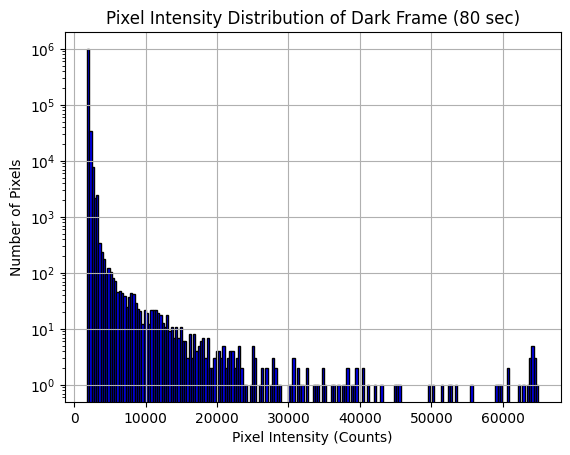

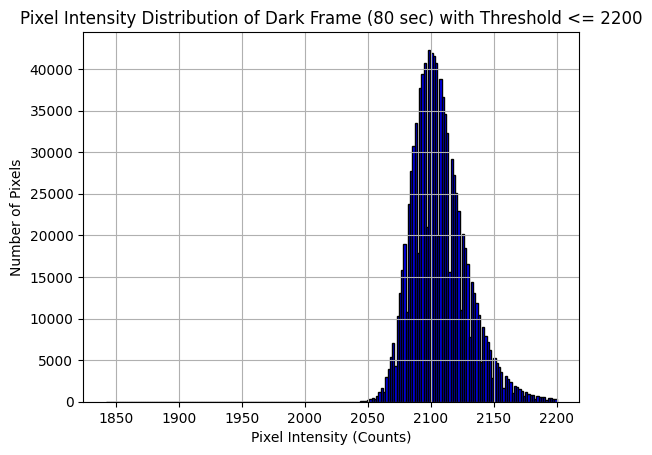

In [223]:
# Define the threshold for filtering
threshold = 2200
# Filtered exposure times
filtered_exposure_times = [80]  # Only putting one time here to make the output not cluttered with graphs of all exposure times

# Process each filtered dark frame individually
for exposure_time in filtered_exposure_times:
    # Get the index of the current exposure time
    i = exposure_times.index(exposure_time)
    # Select the dark frame and combined frame for the current exposure time
    dark_frame = stacked_dark_frames[i]
    combined_frame = stacked_combined_data[i]
    # Flatten the combined frame data into a 1D array
    flattened_combined_data = combined_frame.flatten()
    # Plot the histogram of pixel intensities for the combined dark frame (unfiltered)
    plt.figure()
    plt.hist(flattened_combined_data, bins=200, range=(np.min(flattened_combined_data), np.max(flattened_combined_data)), log=True, color='blue', edgecolor='black')
    plt.title(f'Pixel Intensity Distribution of Dark Frame ({exposure_time} sec)')
    plt.xlabel('Pixel Intensity (Counts)')
    plt.ylabel('Number of Pixels')
    plt.grid(True)
    plt.show()

    # Filter the data based on the threshold
    filtered_data = flattened_combined_data[flattened_combined_data <= threshold]
    # Plot the histogram of pixel intensities for the filtered dark frame
    plt.figure()
    plt.hist(filtered_data, bins=200, range=(np.min(filtered_data), np.max(filtered_data)), color='blue', edgecolor='black')
    plt.title(f'Pixel Intensity Distribution of Dark Frame ({exposure_time} sec) with Threshold <= {threshold}')
    plt.xlabel('Pixel Intensity (Counts)')
    plt.ylabel('Number of Pixels')
    plt.grid(True)
    plt.show()

In [224]:
# Define the filter ranges for each frame
filter_ranges = [1050, 2100, 2200, 2275, 2400, 2450, 2550, 2600, 2700, 2750, 2850, 2900, 3050]
exposure_times = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]  # Include 0 for bias frame
bias_index = 0  # Index for the bias frame

mean_counts_lim = []
st_devs_lim = []
stat_uncs_lim = []

# Include bias frame data separately
with fits.open(bias_file) as hdul_bias:
    bias_data = hdul_bias[0].data
bias_flat_data = bias_data.flatten()

# List of all frame data, including the bias frame
all_frames = [bias_flat_data] + [frame.flatten() for frame in stacked_dark_frames]

# Calculate mean, standard deviation, and statistical uncertainty
for i, flat_data in enumerate(all_frames):
    # Skip the iteration if the exposure time is 80 seconds
    if exposure_times[i] == 80:
        continue  # Skip this iteration
    
    filter_max = filter_ranges[i]
    # Filter data based on the filter range
    filtered_data = flat_data[flat_data <= filter_max]
    # Calculate mean, standard deviation, and statistical uncertainty if there is data
    if filtered_data.size > 0:
        mean = np.mean(filtered_data)
        st_dev = stats.tstd(filtered_data, ddof=1)
        stat_unc = mean / np.sqrt(len(filtered_data))
    else:
        mean = st_dev = stat_unc = np.nan  # Handle the case where filtered data is empty
    
    mean_counts_lim.append(mean)
    st_devs_lim.append(st_dev)
    stat_uncs_lim.append(stat_unc)
    
    # Print results for each frame
    print(f"Exposure Time: {exposure_times[i]} sec, Max Filter: {filter_max}")
    print(f"Mean Counts: {mean}, Standard Deviation: {st_dev}, Statistical Uncertainty: {stat_unc}")


Exposure Time: 0 sec, Max Filter: 1050
Mean Counts: 1002.9957325339666, Standard Deviation: 7.718027122092835, Statistical Uncertainty: 0.9796809712977722
Exposure Time: 10 sec, Max Filter: 2100
Mean Counts: 1010.7619705318742, Standard Deviation: 19.41899813036743, Statistical Uncertainty: 0.9871612060190114
Exposure Time: 20 sec, Max Filter: 2200
Mean Counts: 1018.9100231267698, Standard Deviation: 25.594116234131928, Statistical Uncertainty: 0.9952381506431526
Exposure Time: 30 sec, Max Filter: 2275
Mean Counts: 1027.1538055613871, Standard Deviation: 30.65696413525538, Statistical Uncertainty: 1.0033842291615291
Exposure Time: 40 sec, Max Filter: 2400
Mean Counts: 1035.3524735977157, Standard Deviation: 36.87283287187875, Statistical Uncertainty: 1.0114481867611396
Exposure Time: 50 sec, Max Filter: 2450
Mean Counts: 1042.8813619339592, Standard Deviation: 42.34734492688176, Statistical Uncertainty: 1.018856728439517
Exposure Time: 60 sec, Max Filter: 2550
Mean Counts: 1050.9839809

In [225]:
mean_counts_whole = []
st_devs_whole = []
stat_uncs_whole = []

# Calculate mean, standard deviation, and statistical uncertainty for unfiltered data
for i, flat_data in enumerate(all_frames):
    # Skip the iteration if the exposure time is 80 seconds
    if exposure_times[i] == 80:
        continue  # Skip this iteration

    # No filter applied here
    unfiltered_data = flat_data
    # Calculate mean, standard deviation, and statistical uncertainty if there is data
    if unfiltered_data.size > 0:
        mean = np.mean(unfiltered_data)
        st_dev = stats.tstd(unfiltered_data, ddof=1)  # Sample standard deviation
        stat_unc = mean / np.sqrt(len(unfiltered_data))
    else:
        mean = st_dev = stat_unc = np.nan  # Handle the case where unfiltered data is empty
    
    mean_counts_whole.append(mean)
    st_devs_whole.append(st_dev)
    stat_uncs_whole.append(stat_unc)
    
    # Print results for each frame
    print(f"Exposure Time: {exposure_times[i]} sec")
    print(f"Mean Counts: {mean}, Standard Deviation: {st_dev}, Statistical Uncertainty: {stat_unc}")


Exposure Time: 0 sec
Mean Counts: 1003.057149887085, Standard Deviation: 14.869272117575331, Statistical Uncertainty: 0.9795479979366064
Exposure Time: 10 sec
Mean Counts: 1011.3171682357788, Standard Deviation: 98.23146788071946, Statistical Uncertainty: 0.9876144221052527
Exposure Time: 20 sec
Mean Counts: 1020.2279901504517, Standard Deviation: 123.83317820423197, Statistical Uncertainty: 0.9963163966313004
Exposure Time: 30 sec
Mean Counts: 1029.3027658462524, Standard Deviation: 156.6409813639801, Statistical Uncertainty: 1.005178482271731
Exposure Time: 40 sec
Mean Counts: 1038.3151874542236, Standard Deviation: 191.37723182264267, Statistical Uncertainty: 1.0139796752482653
Exposure Time: 50 sec
Mean Counts: 1046.6994800567627, Standard Deviation: 230.4463528375717, Statistical Uncertainty: 1.0221674609929323
Exposure Time: 60 sec
Mean Counts: 1055.6110725402832, Standard Deviation: 258.9103370397622, Statistical Uncertainty: 1.0308701880276203
Exposure Time: 70 sec
Mean Counts:

Length of exposure_times: 13
Length of stat_uncs_whole: 12
Length of stat_uncs_lim: 12


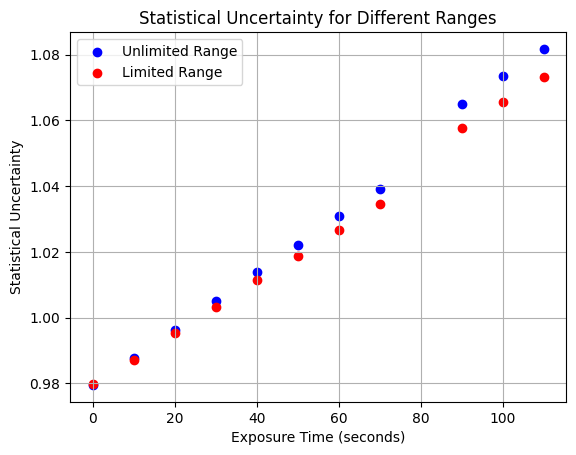

In [226]:
# Initialize the filtered lists
filtered_exposure_times = []
filtered_stat_uncs_whole = []
filtered_stat_uncs_lim = []

# Check the lengths of the lists
print(f"Length of exposure_times: {len(exposure_times)}")
print(f"Length of stat_uncs_whole: {len(stat_uncs_whole)}")
print(f"Length of stat_uncs_lim: {len(stat_uncs_lim)}")

# Use the minimum length to avoid IndexError
min_length = min(len(exposure_times), len(stat_uncs_whole), len(stat_uncs_lim))

# Loop through the exposure times and corresponding uncertainties
for i in range(min_length):
    if exposure_times[i] != 80:  # Check if the exposure time is not 80
        filtered_exposure_times.append(exposure_times[i])
        filtered_stat_uncs_whole.append(stat_uncs_whole[i])  # Use the same index
        filtered_stat_uncs_lim.append(stat_uncs_lim[i])      # Use the same index

# Now the lists should be the same size, and you can plot them
plt.figure()
plt.scatter(filtered_exposure_times, filtered_stat_uncs_whole, label="Unlimited Range", color='blue')
plt.scatter(filtered_exposure_times, filtered_stat_uncs_lim, label="Limited Range", color='red')
plt.title("Statistical Uncertainty for Different Ranges")
plt.xlabel("Exposure Time (seconds)")
plt.ylabel("Statistical Uncertainty")
plt.legend()
plt.grid(True)
plt.show()


Dark Current Rate: 1.7538 ± 0.0360 e-/p/s
Offset: 1000.9453 ± 1.1409


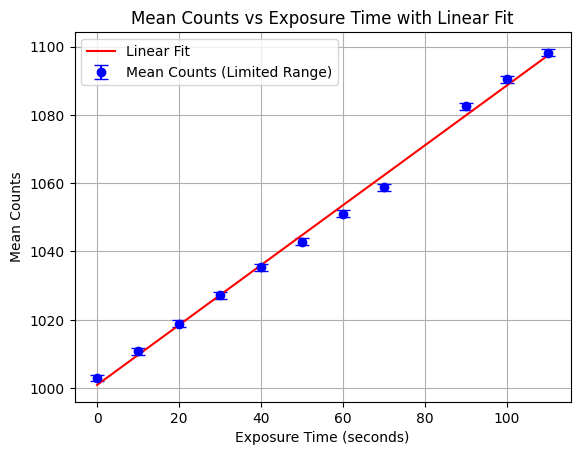

In [227]:
# Define the linear function for fitting
def linear_model(exposure, dark_current_rate, offset):
    """
    Compute the predicted mean counts for a given exposure time based on a linear model.
    """
    return dark_current_rate * exposure + offset

# Initialize filtered lists
filtered_exposure_times = []
filtered_mean_counts_lim = []
filtered_stat_uncs_lim = []

# Loop through exposure times and filter data
for i in range(len(exposure_times)):
    # Ensure we're not exceeding the bounds of the lists
    if i < len(mean_counts_lim) and i < len(stat_uncs_lim):
        if exposure_times[i] != 80:
            filtered_exposure_times.append(exposure_times[i])
            filtered_mean_counts_lim.append(mean_counts_lim[i])  # Accessing using the same index
            filtered_stat_uncs_lim.append(stat_uncs_lim[i])      # Same for stat_uncs_lim

# Now perform a check to ensure all filtered lists are the same length
if len(filtered_exposure_times) != len(filtered_mean_counts_lim) or len(filtered_exposure_times) != len(filtered_stat_uncs_lim):
    print("Length mismatch between filtered lists. Please check the data.")
else:
    # Perform linear regression with the filtered data
    params, covariance = optimize.curve_fit(linear_model, filtered_exposure_times, filtered_mean_counts_lim)
    dark_current_rate, offset = params
    uncertainty_in_dcr = np.sqrt(covariance[0][0])
    uncertainty_in_offset = np.sqrt(covariance[1][1])

    # Gain of STL-1001E camera
    gain = 2  # e-/ADU

    # Adjust dark current rate and its uncertainty by the gain
    dark_current_rate_gain_adjusted = dark_current_rate * gain
    dark_current_rate_uncertainty = uncertainty_in_dcr * gain

    # Print results
    print(f"Dark Current Rate: {dark_current_rate_gain_adjusted:.4f} ± {dark_current_rate_uncertainty:.4f} e-/p/s")
    print(f"Offset: {offset:.4f} ± {uncertainty_in_offset:.4f}")

    # Generate fitted values using the filtered exposure times
    fitted_counts = linear_model(np.array(filtered_exposure_times), *params)

    # Plot the mean counts against exposure time
    plt.figure()
    plt.errorbar(filtered_exposure_times, filtered_mean_counts_lim, yerr=filtered_stat_uncs_lim, 
                 fmt='o', label='Mean Counts (Limited Range)', color='blue', capsize=5)
    plt.plot(filtered_exposure_times, fitted_counts, 'r-', label='Linear Fit')
    plt.title('Mean Counts vs Exposure Time with Linear Fit')
    plt.xlabel('Exposure Time (seconds)')
    plt.ylabel('Mean Counts')
    plt.legend()
    plt.grid(True)
    plt.show()


The farthest mean count is 3.428 sigmas away.


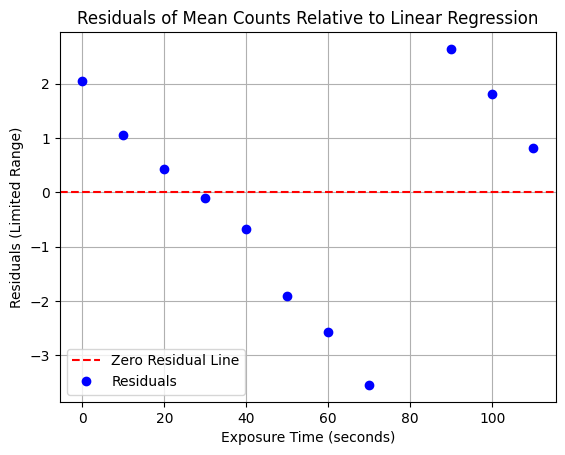

In [228]:
# Calculate residuals by subtracting predicted values from observed mean counts
filtered_residuals = []
filtered_exposure_times = []

# Loop through the data, excluding the point at exposure time 80
for i, count in enumerate(mean_counts_lim):
    if exposure_times[i] != 80:
        predicted_value = linear_model(exposure_times[i], dark_current_rate, offset)
        filtered_residuals.append(count - predicted_value)
        filtered_exposure_times.append(exposure_times[i])

# Calculate the distance of residuals in terms of sigmas
filtered_stat_uncs_lim = [unc for i, unc in enumerate(stat_uncs_lim) if exposure_times[i] != 80]
sigma_distances = np.abs(np.array(filtered_residuals)) / np.array(filtered_stat_uncs_lim)

# Output the farthest mean count in terms of sigmas
farthest_sigma = np.max(sigma_distances)
farthest_index = np.argmax(sigma_distances)
farthest_mean_count = mean_counts_lim[farthest_index]
print(f"The farthest mean count is {farthest_sigma:.3f} sigmas away.")

# Plot the residuals
plt.figure()
plt.errorbar(filtered_exposure_times, filtered_residuals, fmt='o', color='blue', capsize=5, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residuals of Mean Counts Relative to Linear Regression')
plt.xlabel('Exposure Time (seconds)')
plt.ylabel('Residuals (Limited Range)')
plt.legend()
plt.grid(True)
plt.show()


Dark Current Rate: 3.3379 ± 0.0144 e-/p/s


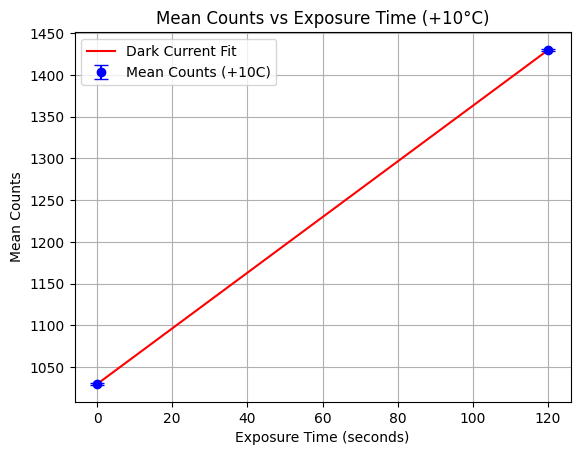

In [229]:
# File paths our Bias Frame and our Dark frame at +10° C
bias_file_10C = r"..\FITS_Files\3.2.4_bias_frame_+10C.00000000.BIAS.FIT"
dark_file_10C_120s = r"..\FITS_Files\3.2.4_dark_frame_120_sec_+10C.00000000.DARK.FIT"

# Define filter limits
bias_filter_max = 1050
dark_filter_max = 3050
exposure_time_dark = 120  # seconds

# Load the bias frame data at +10v C
with fits.open(bias_file_10C) as hdul_bias_10C:
    bias_data_10C = hdul_bias_10C[0].data
bias_flat_data_10C = bias_data_10C.flatten()

# Load the dark frame data at +10°C, 120 sec exposure
with fits.open(dark_file_10C_120s) as hdul_dark_10C_120s:
    dark_data_10C_120s = hdul_dark_10C_120s[0].data
dark_flat_data_10C_120s = dark_data_10C_120s.flatten()

# Filter the bias and dark frame data based on the filter ranges
bias_filtered_10C = bias_flat_data_10C[bias_flat_data_10C <= bias_filter_max]
dark_filtered_10C_120s = dark_flat_data_10C_120s[dark_flat_data_10C_120s <= dark_filter_max]

# Calculate mean, standard deviation, and statistical uncertainty for the bias frame
mean_bias_10C = np.mean(bias_filtered_10C)
st_dev_bias_10C = np.std(bias_filtered_10C, ddof=1)
stat_unc_bias_10C = mean_bias_10C / np.sqrt(len(bias_filtered_10C))

# Calculate mean, standard deviation, and statistical uncertainty for the dark frame
mean_dark_10C_120s = np.mean(dark_filtered_10C_120s)
st_dev_dark_10C_120s = np.std(dark_filtered_10C_120s, ddof=1)
stat_unc_dark_10C_120s = mean_dark_10C_120s / np.sqrt(len(dark_filtered_10C_120s))

# Calculate the dark current (slope) and its uncertainty
dark_current = (mean_dark_10C_120s - mean_bias_10C) / exposure_time_dark
uncertainty_dark_current = np.sqrt(stat_unc_dark_10C_120s**2 + stat_unc_bias_10C**2) / exposure_time_dark

# Print the calculated dark current and its uncertainty
print(f"Dark Current Rate: {dark_current:.4f} ± {uncertainty_dark_current:.4f} e-/p/s")

# Plot the points and the dark current line
exposure_times = [0, exposure_time_dark]
mean_counts = [mean_bias_10C, mean_dark_10C_120s]
stat_uncs = [stat_unc_bias_10C, stat_unc_dark_10C_120s]

# Generate predicted counts using the dark current model
predicted_counts = linear_model(np.array(exposure_times), dark_current, mean_bias_10C)

# Plot the mean counts vs exposure time
plt.figure()
plt.errorbar(exposure_times, mean_counts, yerr=stat_uncs, fmt='o', color='blue', capsize=5, label='Mean Counts (+10C)')
plt.plot(exposure_times, predicted_counts, color='red', label=f"Dark Current Fit")
plt.title('Mean Counts vs Exposure Time (+10°C)')
plt.xlabel('Exposure Time (seconds)')
plt.ylabel('Mean Counts')
plt.legend()
plt.grid(True)
plt.show()